Test ActionVAE

In [12]:
# prepare data
from data_utils import get_data
dataset_used = 'UTDVideo'
train_data_loader, val_data_loader, __ = get_data(dataset_used, 1)

Train size:  774


In [13]:
# load model
from vae import VAE, ActionVAE
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
plt.rcParams['figure.figsize'] = [10, 8]
import torch 

VAEmodel = VAE(latent_dim=512).eval()
VAEmodel_name = 'vae_mark'+str(VAEmodel.mark)+'_UTD'
VAEmodel.load_state_dict(torch.load('models/'+VAEmodel_name+'.pth'))

recurrency = 'rnn'
seq_length = 5
model = ActionVAE(VAEmodel, recurrency=recurrency, seq_length=seq_length)
model_name = 'actionvae_'+recurrency+'_mark'+str(model.mark)+'_'+dataset_used
model.load_state_dict(torch.load('models/'+model_name+'.pth'))

<All keys matched successfully>

In [14]:
# random sample
sample_frame_num = 40
sample = model.sampleVid(sample_frame_num).squeeze(0)
fig, ax = plt.subplots()
plt.close()
frames = []
for i in range(sample_frame_num):
    frame = sample[i].permute(1, 2, 0)
    im = ax.imshow(frame.detach().numpy(), animated=True)
    ax.set_title('Random Sample')
    frames.append([im])
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)

display(HTML(ani.to_html5_video()))

In [15]:
# generate from input
fig, axs = plt.subplots(1, 2)
plt.close()
frames = []
for i, batch in enumerate(val_data_loader):
    vid, label = batch['clip'], batch['label']
    gen = model(vid)[0].squeeze(0)
    vid = vid.squeeze(0)
    frame_num = vid.shape[0]
    for i in range(frame_num):
        frame = vid[i].permute(1, 2, 0)
        im_0 = axs[0].imshow(frame.numpy(), animated=True)
        axs[0].set_title('Input')

        gen_frame = gen[i].permute(1, 2, 0)
        im_1 = axs[1].imshow(gen_frame.cpu().detach().numpy(), animated=True)
        axs[1].set_title('Generation')
        frames.append([im_0, im_1])
    break
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)

display(HTML(ani.to_html5_video()))

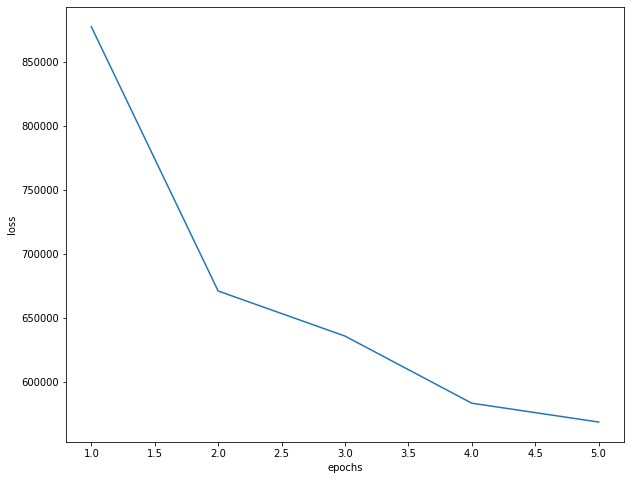

In [16]:
# plot training curve
import json

with open('logs/'+model_name+'.json', 'r') as f:
    losses = json.load(f)

x = range(1, len(losses)+1)
fig, ax = plt.subplots(1, 1)
ax.plot(x, losses)
ax.set_ylabel('loss')
ax.set_xlabel('epochs')
plt.show()